In [1]:
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
from double_net.regret_net import RegretNetUnitDemand
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=1)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=1, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = RegretNetUnitDemand(
    args.n_agents, args.n_items, item_ranges
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

100%|██████████| 100/100 [18:34<00:00, 11.15s/it]


{'regret_max': 0.4061664044857025, 'regret_mean': 0.010267949663102627, 'regret_mults': tensor([[5.6289]], device='cuda:0'), 'payment': 0.254547119140625}
{'regret_max': 0.020214319229125977, 'regret_mean': 0.002893612254410982, 'regret_mults': tensor([[6.0306]], device='cuda:0'), 'payment': 0.38109636306762695}
{'regret_max': 0.01777482032775879, 'regret_mean': 0.0023193247616291046, 'regret_mults': tensor([[6.7479]], device='cuda:0'), 'payment': 0.3959680199623108}
{'regret_max': 0.02067011594772339, 'regret_mean': 0.0020081661641597748, 'regret_mults': tensor([[8.3326]], device='cuda:0'), 'payment': 0.3997638523578644}
{'regret_max': 0.009411215782165527, 'regret_mean': 0.0015308589208871126, 'regret_mults': tensor([[8.9042]], device='cuda:0'), 'payment': 0.40085750818252563}
{'regret_max': 0.018826842308044434, 'regret_mean': 0.0015715836780145764, 'regret_mults': tensor([[9.8529]], device='cuda:0'), 'payment': 0.3997597098350525}
{'regret_max': 0.016560494899749756, 'regret_mean':

In [7]:
orig_dir_name = 'unit_1x2_0_1_experiment_data/'
dir_name = 'regretnet_unit_1x2_0_1_experiment_data/'
test_data = torch.load(orig_dir_name + 'test_data')

In [8]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:06,  6.24s/it]


CPU times: user 6.24 s, sys: 20.1 ms, total: 6.26 s
Wall time: 6.25 s


{'payment_mean': 0.3815626800060272,
 'regret_mean': 0.0001649676269153133,
 'regret_max': 0.0016827583312988281}

In [9]:
def unit_1x2_0_1_optimal_mechanism(bids):
    import math
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 0] > bids[i, 0, 1] and bids[i, 0, 0] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 1.0
            allocs[i, 0, 1] = 0.0
            payments[i] = math.sqrt(3) / 3
        elif bids[i, 0, 1] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 0.0
            allocs[i, 0, 1] = 1.0
            payments[i] = math.sqrt(3) / 3
    return allocs, payments

opt_alloc, opt_payments = unit_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.3926)

In [10]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 100
model.sinkhorn_epsilon = 4e-2

random_starts = [test_data]
for i in range(1):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [00:06,  6.22s/it]


CPU times: user 6.21 s, sys: 24.1 ms, total: 6.23 s
Wall time: 6.22 s


{'payment_mean': 0.3815626800060272,
 'regret_mean': 0.00016138507635332644,
 'regret_max': 0.0016827583312988281}

In [13]:
os.makedirs(dir_name, exist_ok=True)
model.save(dir_name)

In [14]:
cpu_model = RegretNetUnitDemand.load(dir_name).to(device='cpu')

In [15]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    # Plot optimals
    ax1.plot([math.sqrt(3) / 3, math.sqrt(3) / 3], [0, math.sqrt(3) / 3], 'k--')
    ax1.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    ax2.plot([0, math.sqrt(3) / 3], [math.sqrt(3) / 3, math.sqrt(3) / 3], 'k--')
    ax2.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

<ipython-input-15-6ac70bc976da>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


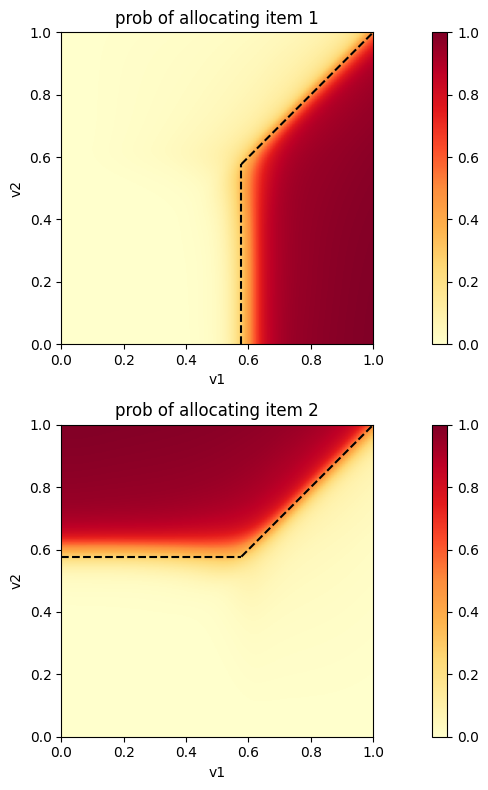

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 4e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

<ipython-input-15-6ac70bc976da>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


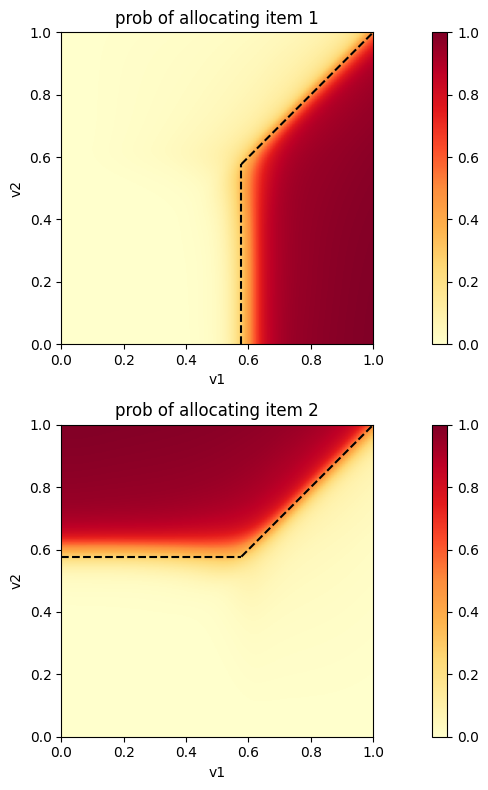

In [17]:
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

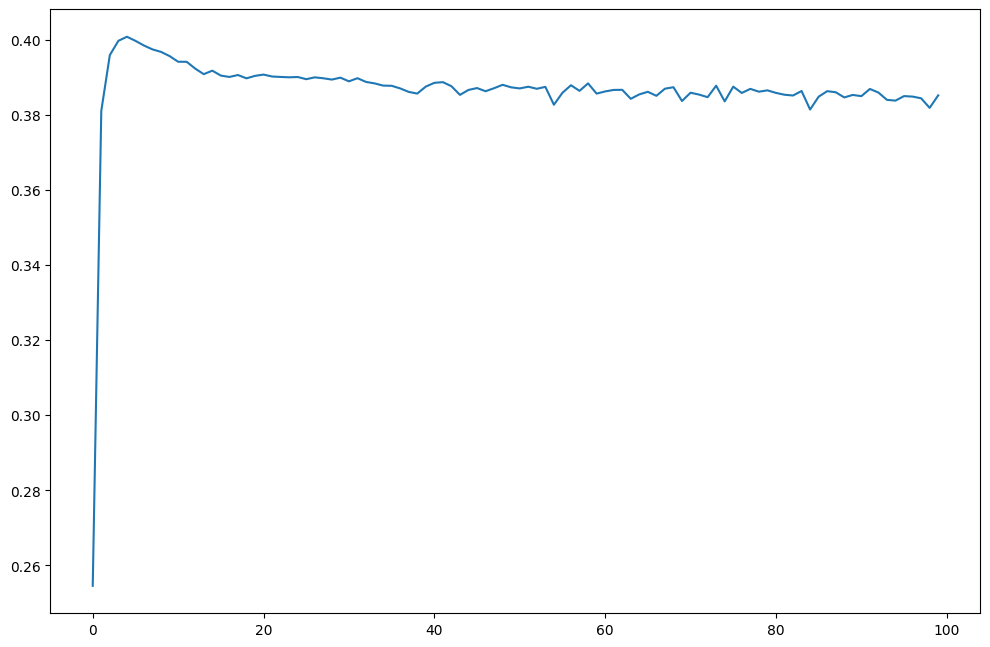

In [18]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [19]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)